In [2]:
# 1. Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')
import os
from src.utils.metrics import obtener_ruta_app

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [4]:
def cargar_datos(archivo_csv):
    """
    Carga los datos desde un archivo CSV con fecha como índice
    """
    df = pd.read_csv(archivo_csv, parse_dates=['fecha'], index_col='fecha')
    df = df.sort_index()  # Asegurar orden cronológico
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"Rango de fechas: {df.index.min()} a {df.index.max()}")
    return df

In [5]:
base_path = obtener_ruta_app("TemplateAgroIA")
file_path = os.path.join(base_path, "data", "processed", "rnn", "rnn_produccion.csv")
df = cargar_datos(file_path)

Datos cargados: 630 filas, 11 columnas
Rango de fechas: 2015-01-01 00:00:00 a 2025-06-01 00:00:00


In [6]:
def visualizar_serie(df, columna='produccion'):
    """
    Visualiza la serie temporal de producción
    """
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[columna], linewidth=2)
    plt.title(f'Serie Temporal de {columna.capitalize()}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel(f'{columna.capitalize()}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas
    print(f"\nEstadísticas de {columna}:")
    print(df[columna].describe())

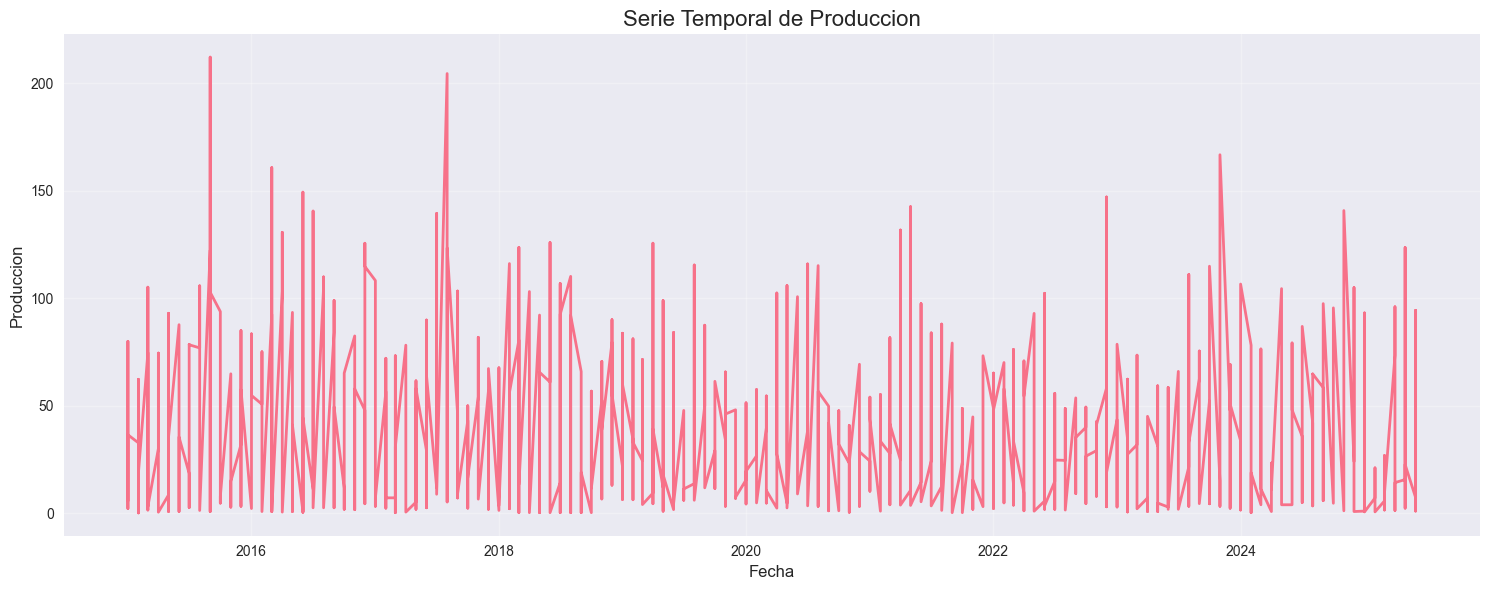


Estadísticas de produccion:
count    630.000000
mean      39.061247
std       36.269663
min        0.049000
25%        7.070000
50%       31.850000
75%       58.441250
max      212.050000
Name: produccion, dtype: float64


In [7]:
visualizar_serie(df)

In [8]:
def dividir_train_test(df, columna='produccion', meses_test=48):
    """
    Divide los datos en entrenamiento y prueba
    """
    serie = df[columna].values.reshape(-1, 1)

    # Punto de corte
    split_point = len(serie) - meses_test

    train_data = serie[:split_point]
    test_data = serie[split_point:]

    print(f"Datos de entrenamiento: {len(train_data)} meses")
    print(f"Datos de prueba: {len(test_data)} meses")

    return train_data, test_data, split_point

In [9]:
train_data, test_data, split_point = dividir_train_test(df, meses_test=32)

Datos de entrenamiento: 598 meses
Datos de prueba: 32 meses


In [10]:
def escalar_datos(train_data, test_data):
    """
    Escala los datos usando MinMaxScaler
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    return train_scaled, test_scaled, scaler


In [11]:
train_scaled, test_scaled, scaler = escalar_datos(train_data, test_data)

In [46]:
def crear_generadores(train_scaled, test_scaled, length=6, batch_size=128):
    """
    Crea generadores de secuencias temporales
    """
    train_generator = TimeseriesGenerator(
        train_scaled, train_scaled,
        length=length,
        batch_size=batch_size
    )

    test_generator = TimeseriesGenerator(
        test_scaled, test_scaled,
        length=length,
        batch_size=batch_size
    )

    return train_generator, test_generator

In [47]:
length = 6 # Usar 12 meses anteriores para predecir
train_generator, test_generator = crear_generadores(train_scaled, test_scaled, length=length)

In [48]:
def crear_modelo_lstm(input_shape, units=80, dropout_rate=0.15):
    """
    Crea el modelo LSTM
    """
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

In [49]:
model = crear_modelo_lstm(input_shape=(length, 1),)
print("\nArquitectura del modelo:")
model.summary()


Arquitectura del modelo:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 80)          │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         2,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,811 (311.76 KB)

 Trainable params: 79,811 (311.76 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def entrenar_modelo(model, train_generator, test_generator, epochs, patience=10):
    """
    Entrena el modelo con EarlyStopping
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        callbacks=[early_stopping],
        verbose=1
    )

    return history

In [51]:
print("\nIniciando entrenamiento...")
history = entrenar_modelo(model, train_generator, test_generator, epochs=800, patience=80)


Iniciando entrenamiento...
Epoch 1/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0455 - mae: 0.1584 - val_loss: 0.0315 - val_mae: 0.1430
Epoch 2/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0274 - mae: 0.1329 - val_loss: 0.0381 - val_mae: 0.1853
Epoch 3/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - mae: 0.1423 - val_loss: 0.0317 - val_mae: 0.1517
Epoch 4/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0297 - mae: 0.1362 - val_loss: 0.0318 - val_mae: 0.1435
Epoch 5/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0279 - mae: 0.1299 - val_loss: 0.0319 - val_mae: 0.1508
Epoch 6/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0326 - mae: 0.1442 - val_loss: 0.0332 - val_mae: 0.1636
Epoch 7/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0316 - mae: 0.1450 - val_loss: 0.0332 - val_mae: 0.1634
Epoch 8/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0330 - mae: 0.1477 - val_loss: 0.0324 - val_mae: 0.1577
Epoch 9/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

In [52]:
def evaluar_modelo(model, test_generator, scaler, df, split_point):
    """
    Evalúa el modelo y genera predicciones
    """
    # Predicciones
    predictions_scaled = model.predict(test_generator)
    predictions = scaler.inverse_transform(predictions_scaled)

    # Valores reales (ajustar por el desfase del generador)
    length = test_generator.length
    real_values = df['produccion'].iloc[split_point + length:].values

    # Métricas
    mae = mean_absolute_error(real_values, predictions.flatten())
    mse = mean_squared_error(real_values, predictions.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(real_values, predictions.flatten())

    print(f"\nMétricas de evaluación:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    return predictions, real_values

In [53]:
predictions, real_values = evaluar_modelo(model, test_generator, scaler, df, split_point)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

Métricas de evaluación:
MAE: 30.3228
MSE: 1415.0182
RMSE: 37.6167
R²: 0.0489


In [35]:
#Guardar el modelo
base_path = obtener_ruta_app("TemplateAgroIA")
model_path = os.path.join(base_path, "models", "modelo_RNN_Papas.h5")
print("Model path:", model_path)
# Guarda el modelo
model.save(model_path)
print("Modelo guardado con éxito.")

Model path: C:\TemplateAgroIA\models\modelo_RNN_Papas.h5
Modelo guardado con éxito.


In [36]:
def forecast_futuro(model, df, scaler, length=12, pasos_futuros=6):
    """
    Realiza predicciones futuras
    """
    # Obtener los últimos valores para iniciar el forecast
    last_sequence = df['produccion'].tail(length).values.reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)

    forecast = []
    current_sequence = last_sequence_scaled.copy()

    for _ in range(pasos_futuros):
        # Predecir siguiente valor
        next_pred = model.predict(current_sequence.reshape(1, length, 1), verbose=0)
        forecast.append(next_pred[0, 0])

        # Actualizar secuencia
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    # Desescalar predicciones
    forecast = np.array(forecast).reshape(-1, 1)
    forecast_unscaled = scaler.inverse_transform(forecast)

    return forecast_unscaled.flatten()

In [37]:
forecast = forecast_futuro(model, df, scaler, length=length, pasos_futuros=6)
print(f"\nForecast para los próximos 6 meses:")
for i, pred in enumerate(forecast, 1):
    print(f"Mes {i}: {pred:.2f}")


Forecast para los próximos 6 meses:
Mes 1: 54.25
Mes 2: 55.61
Mes 3: 56.92
Mes 4: 58.14
Mes 5: 59.21
Mes 6: 60.38


In [38]:

def graficar_predicciones(predictions, real_values, forecast, df, split_point, length=36, pasos_futuros=6):
    """
    Grafica solo las predicciones, valores reales y forecast
    """
    plt.figure(figsize=(16, 8))

    # Fechas para predicciones en test
    test_dates = df.index[split_point + length:]

    # Solo predicciones vs reales
    plt.plot(test_dates, real_values, label='Valores Reales', color='green', linewidth=3, marker='o')
    plt.plot(test_dates, predictions.flatten(), label='Predicciones', color='red', linewidth=3, marker='s')

    # Forecast futuro
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=pasos_futuros, freq='MS')
    plt.plot(future_dates, forecast, label='Forecast Futuro', color='orange', linewidth=3, linestyle='--', marker='^')

    plt.title('Predicciones vs Valores Reales - Modelo LSTM', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Producción', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

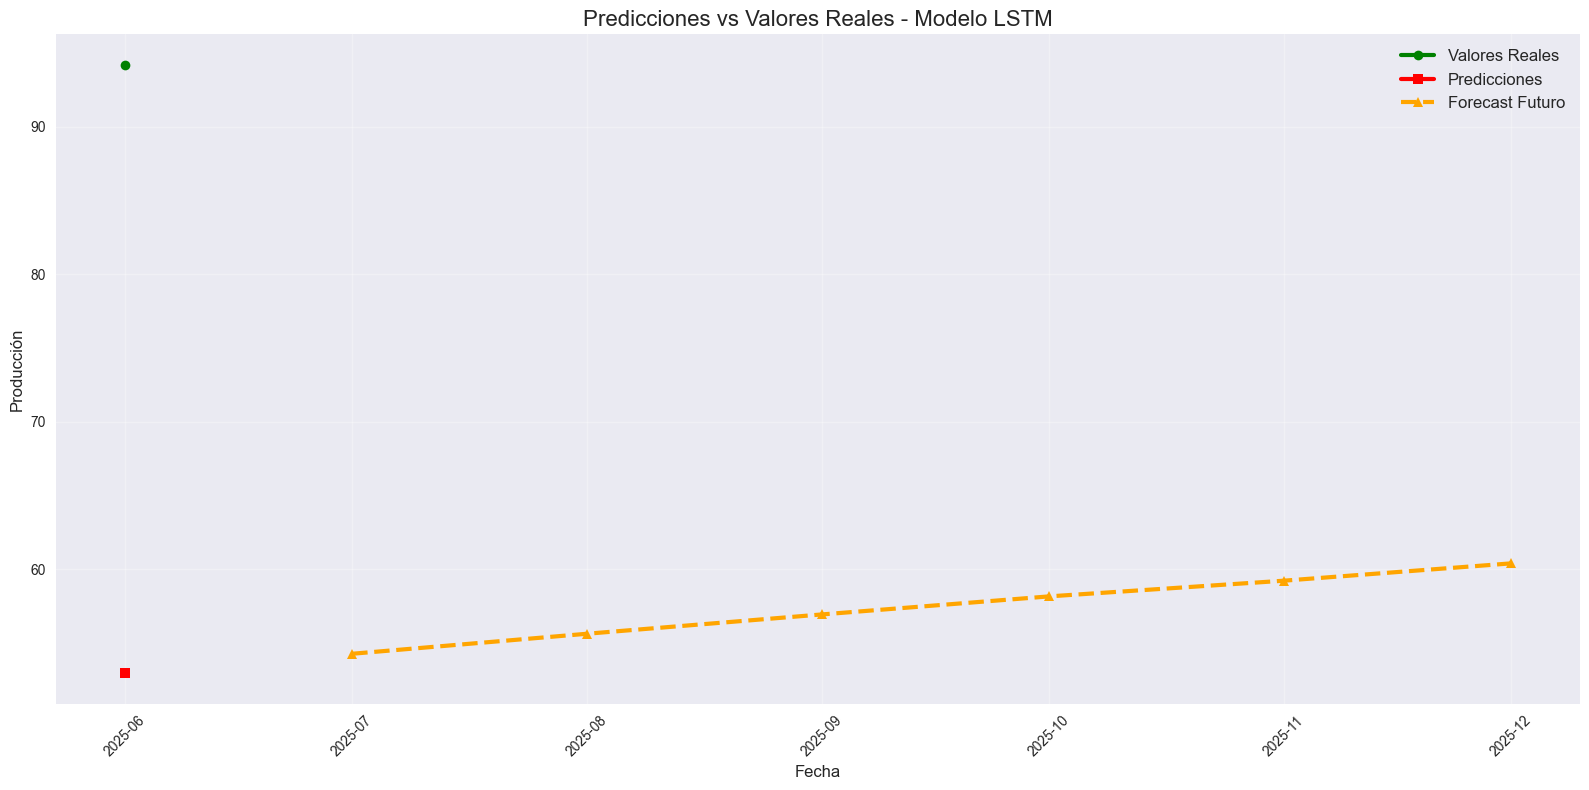

In [39]:
graficar_predicciones(predictions, real_values, forecast, df, split_point, length, pasos_futuros=6)

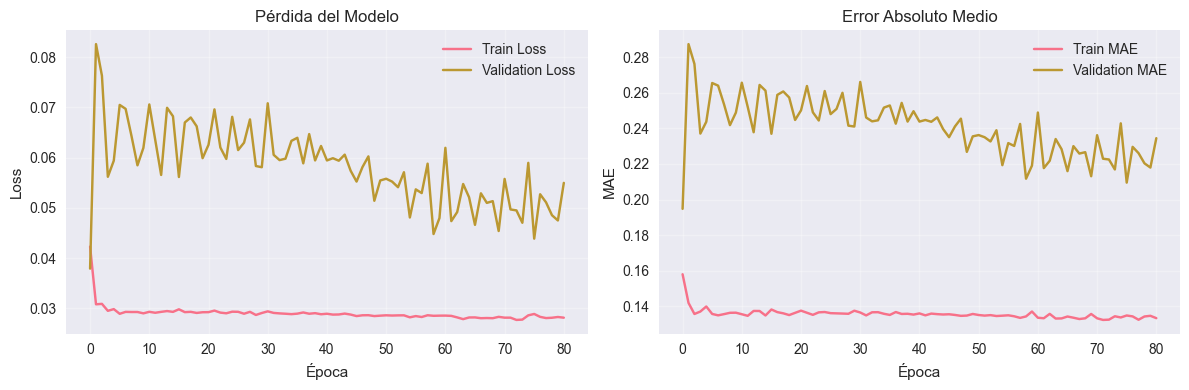

In [40]:
# Graficar curvas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [54]:
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'length': [6, 12, 24],
    'batch_size': [32, 64, 128],
    'learning_rate': [1e-4, 1e-3, 1e-2]
}


In [55]:
def probar_combinacion(units, dropout_rate, length, batch_size, learning_rate):
    # Re-crear datos con la nueva ventana
    train_generator, test_generator = crear_generadores(train_scaled, test_scaled, length=length, batch_size=batch_size)

    # Crear nuevo modelo
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(length, 1)),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Entrenar modelo (usá early stopping si querés acortar tiempos)
    history = model.fit(train_generator, validation_data=test_generator, epochs=50, verbose=0)

    # Evaluar en test
    predictions = model.predict(test_generator)
    predictions = scaler.inverse_transform(predictions)
    real = df['produccion'].iloc[split_point + length:].values

    mae = mean_absolute_error(real, predictions)
    rmse = np.sqrt(mean_squared_error(real, predictions))
    r2 = r2_score(real, predictions)

    return mae, rmse, r2


In [ ]:
import itertools

resultados = []
for combo in itertools.product(*param_grid.values()):
    units, dropout_rate, length, batch_size, lr = combo
    mae, rmse, r2 = probar_combinacion(units, dropout_rate, length, batch_size, lr)
    resultados.append({
        'units': units,
        'dropout': dropout_rate,
        'length': length,
        'batch_size': batch_size,
        'lr': lr,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    })
    print(f"✓ Combinación probada: {combo} -> MAE: {mae:.2f}, R²: {r2:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
✓ Combinación probada: (32, 0.1, 6, 32, 0.0001) -> MAE: 33.77, R²: 0.017


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
✓ Combinación probada: (32, 0.1, 6, 32, 0.001) -> MAE: 33.24, R²: 0.025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
✓ Combinación probada: (32, 0.1, 6, 32, 0.01) -> MAE: 35.82, R²: -0.040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
✓ Combinación probada: (32, 0.1, 6, 64, 0.0001) -> MAE: 34.07, R²: 0.009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
✓ Combinación probada: (32, 0.1, 6, 64, 0.001) -> MAE: 34.67, R²: -0.009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
✓ Combinación probada: (32, 0.1, 6, 64, 0.01) -> MAE: 37.14, R²: -0.081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
✓ Combinación probada: (32, 0.1, 6, 128, 0.0001) -> MAE: 33.92, R²: 0.013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
✓ Combinación probada: (32, 0.1, 6, 128, 0.001) -> MAE: 34.49, R²: 0.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
✓ Combinación probada: (32, 0.1, 6, 128, 0.01) -> MAE: 33.53, R²: 0.026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
✓ Combinación probada: (32, 0.1, 12, 32, 0.0001) -> MAE: 34.80, R²: 